In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dog-cat/vit-cat-dog/dogs/dog1023.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog1878.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog1081.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog3445.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog515.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog171.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog2541.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog2448.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog1047.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog2379.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog1995.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog110.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog2315.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog1488.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog3647.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog294.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog2112.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog1581.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog2039.jpg
/kaggle/input/dog-cat/vit-cat-dog/d

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

import os
import cv2
import numpy as np
from PIL import Image
from dataclasses import dataclass

import matplotlib.pyplot as plt

In [6]:
# path = os.path.join ("vit-cat-dog", "cats", 'cat2.jpg')
# path = os.path.join ("/", "kaggle", "input", "dog-cat", "vit-cat-dog", "dogs", 'dog2.jpg')
path = os.path.join ("vit-cat-dog", "dogs", 'dog2.jpg')

In [7]:
image = Image.open (path)

transform = transforms.Compose ([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

img = transform (image)

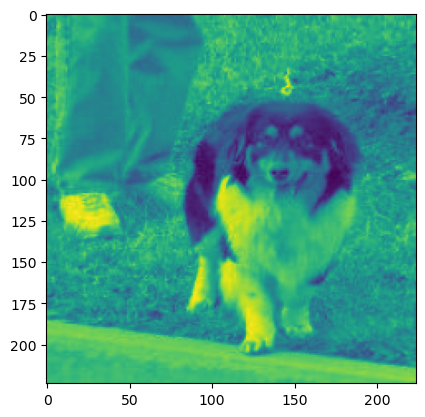

In [8]:
plt.imshow (img.permute (1, 2, 0))

In [9]:
@dataclass
class ViTConfig:
    def __init__ (self, **kwargs):
        for k, v in kwargs.items ():
            setattr (self, k, v)
        self.d_k = self.d_model // self.n_head
        self.tok_len = self.patch_size ** 2

        # add one bacuause of the prediction token
        self.seq_len = (self.h_image // self.patch_size) * (self.w_image // self.patch_size) + 1

In [10]:
C, H, W = img.shape
C, H, W

(1, 224, 224)

In [11]:
config = ViTConfig (
    n_head=4,
    n_layer=2,
    d_model=224,
    h_image=H,
    w_image=W,
    epochs=50,
    patch_size=16,
    chan_mul=2,
    batch_size=4
)

In [12]:
class PatchTokenizer (nn.Module):
    def __init__ (self, config: ViTConfig):
        super (PatchTokenizer, self).__init__ ()

        self.windows = nn.Unfold (kernel_size=config.patch_size, stride=config.patch_size, padding=0)

        # projection for converting into the required dimention using nn.Linear ()
        self.project = nn.Linear ((config.patch_size ** 2), config.tok_len)

    def forward (self, x):
        # transpose for multiplying (a, b) with (b, a)
        x = self.windows (x).transpose (1, 2)
        x = self.project (x)
        return x

In [13]:
class LearnablePositionalEncoder (nn.Module):
    def __init__ (self, config: ViTConfig):
        super (LearnablePositionalEncoder, self).__init__ ()
        self.pos_encoding = nn.Parameter (torch.zeros (1, config.seq_len, config.tok_len))

    def forward (self, x):
        out = self.pos_encoding + x
        return out

In [14]:
class Head (nn.Module):
    def __init__ (self, config: ViTConfig):
        super (Head, self).__init__ ()

        self.query = nn.Linear (config.d_model, config.d_k)
        self.key = nn.Linear (config.d_model, config.d_k)
        self.value = nn.Linear (config.d_model, config.d_k)

        self.linear = nn.Linear (config.d_k, config.d_k)

    def forward (self, x):

        # x.shape (batch, seq_len, d_model)
        B, T, D = x.shape

        Q = self.query (x)
        K = self.key (x)
        V = self.value (x)

        attn = Q @ K.permute (0, 2, 1)
        attn = attn / config.d_k
        attn = F.softmax (attn, dim=-1)
        out = (attn @ V)
        out = self.linear (out)

        return out

In [15]:
class Attention (nn.Module):
    def __init__ (self, config: ViTConfig):
        super (Attention, self).__init__ ()

        self.heads = nn.ModuleList ([Head (config) for _ in range (config.n_head)])
        self.linear = nn.Linear (config.n_head * config.d_k, config.d_model)

    def forward (self, x):
        out = torch.cat ([head (x) for head in self.heads], dim=-1)
        out = self.linear (out)
        return out

In [16]:
class FeedForward (nn.Module):
    def __init__ (self, config: ViTConfig):
        super (FeedForward, self).__init__ ()

        self.fc1 = nn.Linear (config.d_model, config.d_model * config.chan_mul)
        self.fc2 = nn.Linear (config.d_model * config.chan_mul, config.d_model)
        self.activation = nn.GELU ()

    def forward (self, x):
        x = self.fc1 (x)
        x = self.activation (x)
        x = self.fc2 (x)
        return x

In [17]:
class Encoder (nn.Module):
    def __init__ (self, config: ViTConfig):
        super (Encoder, self).__init__ ()

        self.norm1 = nn.LayerNorm (config.d_model)
        self.norm2 = nn.LayerNorm (config.d_model)

        self.attention = Attention (config)
        self.feed_forward = FeedForward (config)

    def forward (self, x):
        x = x + self.attention (self.norm1 (x))
        x = x + self.feed_forward (self.norm2 (x))
        return x

In [18]:
class ViT (nn.Module):
    def __init__ (self, config: ViTConfig):
        super (ViT, self).__init__ ()

        self.wpe = LearnablePositionalEncoder (config)
        self.cls = nn.Parameter (torch.zeros (1, 1, config.tok_len))
        self.project = nn.Linear (config.tok_len, config.d_model)

        self.blocks = nn.Sequential (*[Encoder (config)
                                       for _ in range (config.n_layer)])

        self.linear = nn.Linear (config.d_model, 1)

    def forward (self, x):
        B, T, D = x.shape

        x = torch.cat ((self.cls.expand (B, -1, -1), x), dim=1)
        x = self.wpe (x)
        x = self.project (x)

        out = self.blocks (x)
        out = out[:, 0]
        logits = self.linear (out)

        return logits

In [19]:
class ViTModel (nn.Module):
    def __init__ (self, config: ViTConfig):
        super (ViTModel, self).__init__ ()

        self.patch_tokens = PatchTokenizer (config)
        self.vit = ViT (config)

    def forward (self, x):
        # x (C, H, W)
        x = self.patch_tokens (x) # x (B, T, D)
        x = self.vit (x)

        return x

In [20]:
class CatDogDataset (Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label, class_name in enumerate(['cats', 'dogs']):
            class_dir = os.path.join(root_dir, class_name)
            for file_name in os.listdir(class_dir):
                if file_name[0] == '.':
                    continue

                self.image_paths.append(os.path.join(class_dir, file_name))
                self.labels.append(label)

    def __len__(self):
        return len (self.labels)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [45]:
transform = transforms.Compose ([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# cat_dog = CatDogDataset (os.path.join ('/', 'kaggle', 'input', 'dog-cat', 'vit-cat-dog'), transform=transform)
cat_dog = CatDogDataset (os.path.join ('vit-cat-dog'), transform=transform)

In [46]:
train_size = int(0.8 * len(cat_dog))
test_size = len(cat_dog) - train_size
train_dataset, test_dataset = random_split(cat_dog, [train_size, test_size])

In [47]:
train = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
test = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

In [21]:
# device = torch.device ('cuda')
device = torch.device ('mps')
device

device(type='mps')

In [27]:
vit = ViTModel (config)
vit = vit.to (torch.device ('cpu'))

In [23]:
criterion = nn.BCEWithLogitsLoss ()
optimizer = optim.Adam (vit.parameters (), lr=0.001)

In [41]:
def calculate_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            probabilities = torch.sigmoid(outputs).view(-1)
            predictions = (probabilities >= 0.5).float()
            
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
    
    accuracy = correct / total
    return accuracy

In [42]:
for epoch in range (config.epochs):
    accum_loss = 0.0

    for images, labels in train:
        if images.shape[0] != config.batch_size:
            continue

        optimizer.zero_grad ()

        images = images.to (device)
        labels = labels.float ().to (device)

        out = vit (images)
        loss = criterion (out, labels.unsqueeze (1))
        loss.backward ()

        accum_loss += loss.item ()

        optimizer.step ()
        
    test_accuracy = calculate_accuracy(vit, test, device)
    avg_loss = accum_loss / len (dataset)
    
    print(f'Epoch ({epoch+1}/{config.epochs}), Loss: ({avg_loss:.4f}) Test Acc: ({test_accuracy:.4f})')

Epoch (1/50), Loss: (0.5583) Test Acc: (0.5059)
Epoch (2/50), Loss: (0.5580) Test Acc: (0.5028)
Epoch (3/50), Loss: (0.5608) Test Acc: (0.5034)
Epoch (4/50), Loss: (0.5607) Test Acc: (0.4997)
Epoch (5/50), Loss: (0.5551) Test Acc: (0.4997)
Epoch (6/50), Loss: (0.5512) Test Acc: (0.5429)
Epoch (7/50), Loss: (0.5501) Test Acc: (0.5435)
Epoch (8/50), Loss: (0.5488) Test Acc: (0.5626)
Epoch (9/50), Loss: (0.5508) Test Acc: (0.5490)
Epoch (10/50), Loss: (0.5456) Test Acc: (0.5614)
Epoch (11/50), Loss: (0.5475) Test Acc: (0.5620)
Epoch (12/50), Loss: (0.5420) Test Acc: (0.5620)
Epoch (13/50), Loss: (0.5444) Test Acc: (0.5645)
Epoch (14/50), Loss: (0.5413) Test Acc: (0.5601)
Epoch (15/50), Loss: (0.5549) Test Acc: (0.5614)
Epoch (16/50), Loss: (0.5393) Test Acc: (0.5534)
Epoch (17/50), Loss: (0.5413) Test Acc: (0.5595)
Epoch (18/50), Loss: (0.5372) Test Acc: (0.5645)
Epoch (19/50), Loss: (0.5374) Test Acc: (0.5904)
Epoch (20/50), Loss: (0.5308) Test Acc: (0.5731)
Epoch (21/50), Loss: (0.5267)

In [43]:
# torch.save (vit.state_dict (), 'kaggle_vit.pth')

In [37]:
# path = os.path.join ("/", "kaggle", "input", "dog-cat", "vit-cat-dog", "cats", 'cat200.jpg')
path = os.path.join ("vit-cat-dog", "dogs", 'dog20.jpg')

In [38]:
image = Image.open (path)

transform = transforms.Compose ([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

img = transform (image)

In [79]:
nn.Sigmoid () (vit (img.unsqueeze (0).to (device)))

tensor([[0.1942]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [50]:
calculate_accuracy (vit, train, torch.device ('cpu'))

0.5047046120623169

In [24]:
vit.load_state_dict (torch.load ('kaggle.pth', map_location=torch.device ('cpu')))

<All keys matched successfully>

In [39]:
vit (img.unsqueeze (0))

tensor([[0.0800]], grad_fn=<AddmmBackward0>)